# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [ ]:
import numpy as np
D = np.loadtxt('lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [ ]:
import numpy as np
import torch

D = np.loadtxt('lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

X = torch.hstack((torch.ones(X.shape[0], 1), X))

In [ ]:
from tqdm.notebook import tqdm


def mse(y_true, y_pred):
    return (y_true - y_pred).pow(2).mean()


class LinearRegression:
    def __init__(self, lr=0.001, momentum=0.9, loss=mse, regulization="L2", alpha=0.1, epochs=100, batch_size=100):
        self.lr = lr
        self.momentum = momentum
        self.loss = loss
        self.reguliztion = regulization
        self.alpha = alpha
        self.batch_size=batch_size
        
        self.theta = None
        self.losses = None
        self.prev_grad = 0
        self.epochs = 100
        
    def fit(self, X, y, disable_bar=False):
        self.theta = torch.rand(X.shape[1], requires_grad=True)
        
        epoch = 0
        self.losses = []
        n_iters = X.shape[0] // self.batch_size
        
        for epoch in tqdm(range(self.epochs), disable=disable_bar):
            loss_acc = 0
            for i in range(n_iters):
                y_pred = X[i * self.batch_size: (i + 1) * self.batch_size] @ self.theta
                loss = self.loss(y[i * self.batch_size: (i + 1) * self.batch_size], y_pred)

                if self.reguliztion == "L2":
                    loss += self.alpha * torch.norm(self.theta)

                loss.backward()

                with torch.no_grad():
                    loss_acc += loss.item()

                    grad = self.lr * self.theta.grad
                    if self.momentum:
                        grad += self.momentum * self.prev_grad

                    self.theta -= grad
                    self.prev_grad = grad

                    self.theta.grad.zero_()
                        
            self.losses.append(loss_acc / n_iters)

    
    def predict(self, X):
        return X @ self.theta

No handles with labels found to put in legend.


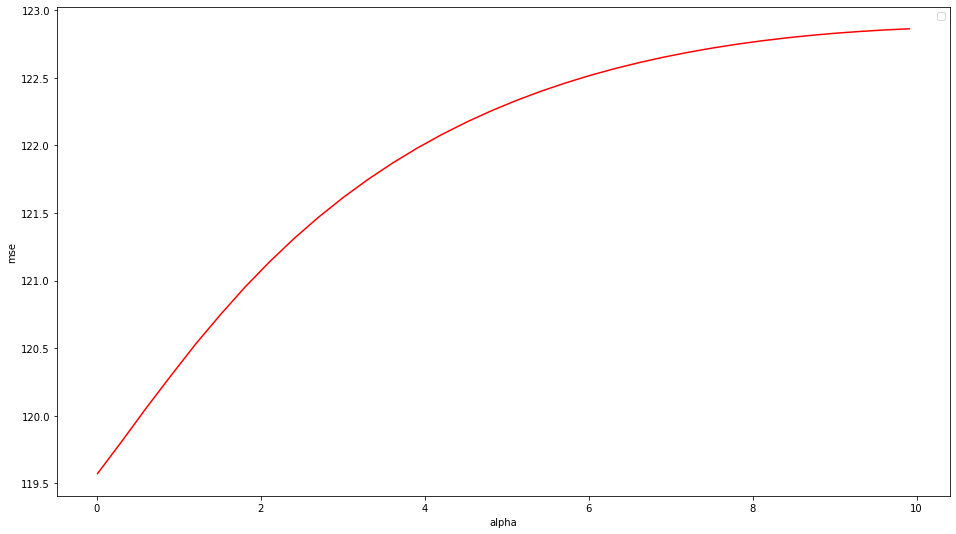

In [ ]:
import matplotlib.pyplot as plt


def plot_alpha(losses, alphas, label, color="r"):
    plt.plot(alphas, losses, color=color, label=label)
    plt.xlabel("alpha")
    plt.ylabel("mse")

alpha_losses = []
train_losses = []
alphas = np.arange(0.01, 10, 0.3)

for a in alphas:
    reg = LinearRegression(alpha=a)

    reg.fit(X, Y, disable_bar=True)
    
    y_pred = reg.predict(X)
    alpha_losses.append(mse(Y, y_pred))

plt.figure(figsize=(16, 9))
plot_alpha(alpha_losses, alphas, label='')
plt.legend()
plt.show()

In [ ]:
class CrossVal:
    def __init__(self, n_items, n_folds=5):
        self.n_items = n_items
        self.n_folds = n_folds
    
    def splits(self):
        indicies = np.arange(self.n_items)
        split_size = self.n_items // self.n_folds
        
        for i in range(self.n_folds):
            train_indicies = indicies[0: i * split_size]
            train_indicies = np.hstack((train_indicies, indicies[(i+1) * split_size:]))
            
            val_indicies = indicies[i * split_size: (i + 1) * split_size]
            yield (train_indicies, val_indicies)

In [ ]:
def cross_val_score(Regressor, X, y, n_folds=5, **params):
    reg = Regressor(**params)
    
    scores = np.zeros(n_folds)
    train_scores = np.zeros(n_folds)
    cv = CrossVal(X.shape[0])

    for i, (train_indicies, val_indicies) in enumerate(cv.splits()):
        reg.fit(X[train_indicies], y[train_indicies], disable_bar=True)
        y_pred = reg.predict(X[val_indicies])
        scores[i] = mse(y[val_indicies], y_pred)
        y_pred = reg.predict(X[train_indicies])
        train_scores[i] = mse(y[train_indicies], y_pred)
        
    return scores, train_scores

In [ ]:
import random

class RandomSearchCV:
    def __init__(self, n_trials, params_bound, n_folds=5):
        self.n_trials = n_trials
        self.params_bound = params_bound
        self.n_folds = n_folds
        
    def search(self, Regressor, X, y):
        scores = []
        for i in tqdm(range(self.n_trials)):
            params = {
                key: random.uniform(v[0], v[1])
                for key, v in self.params_bound.items()
            }
            scores.append({
                "params": params,
                "scores": cross_val_score(Regressor, X, y, n_folds=self.n_folds, **params)[0].mean()
            })
        return scores

In [ ]:
search = RandomSearchCV(100, {
    "lr": (0.001, 0.00001),
    "alpha": (0.1, 10),
    "momentum": (0.5, 0.95)
})

results = search.search(LinearRegression, X, Y)

In [ ]:
sorted(results, key=lambda x: x["scores"])[0]

{'params': {'alpha': 0.3322066931156269,
  'lr': 0.0007766819168952023,
  'momentum': 0.9324095523714198},
 'scores': 96.90172119140625}

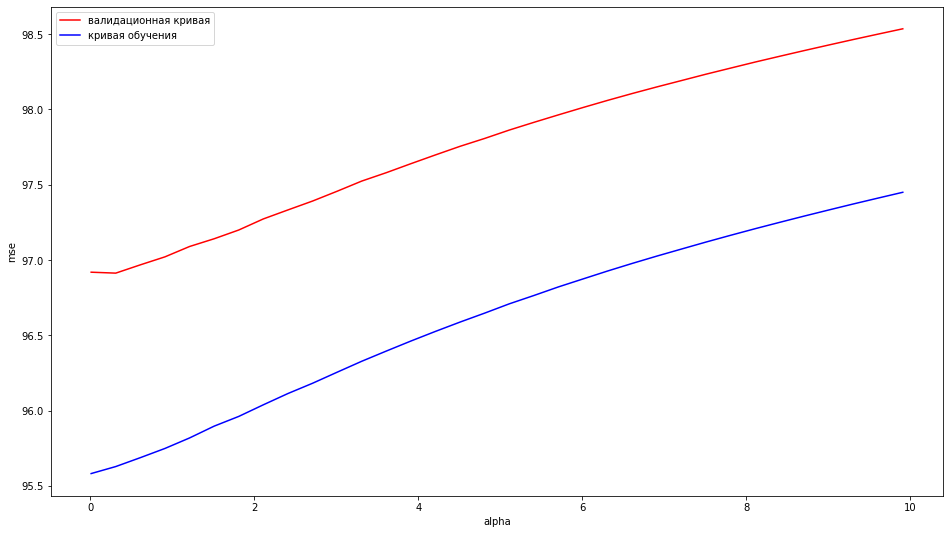

In [ ]:
alpha_losses = []
train_losses = []
alphas = np.arange(0.01, 10, 0.3)

for a in alphas:
    scores, train_scores = cross_val_score(LinearRegression, X, Y, alpha=a, momentum=0.8829630106771027, lr=0.0006148605325817324)
    alpha_losses.append(scores.mean())
    train_losses.append(train_scores.mean())
    
plt.figure(figsize=(16, 9))
plot_alpha(alpha_losses, alphas, label="валидационная кривая")
plot_alpha(train_losses, alphas, color='blue', label="кривая обучения")
plt.legend()
plt.show()